C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


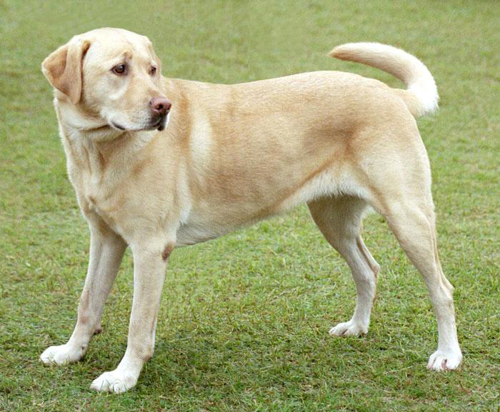

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

def download(url, max_dim=None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

def deprocess(img):
    img = 255 * (img + 1.0) / 2.0
    return tf.cast(img, tf.uint8)

def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))

original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))



In [2]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')


In [3]:
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)



In [4]:
def calc_loss(img, model):
    img_batch = tf.expand_dims(img, axis=0)
    layers_activations = model(img_batch)

    losses = []
    for act in layers_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
    return tf.reduce_sum(losses)

In [6]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model
    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img)
                loss = calc_loss(img, self.model)
            gradients = tape.gradient(loss, img)
            # Normalize th gradient
            gradients /= tf.math.reduce_std(gradients) + 1e-8
            
            img = img + gradients * step_size
            img = tf.clip_by_value(img, -1, 1)
        
        return loss, img

In [8]:
deepdream = DeepDream(dream_model)

In [17]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining > 100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps
        
        loss, img = deepdream(img, run_steps, tf.constant(step_size))
        
        display.clear_output(wait=True)
        show(deprocess(img))
        print("Step {}, loss {}".format(step, loss))
    
    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)
    
    return result

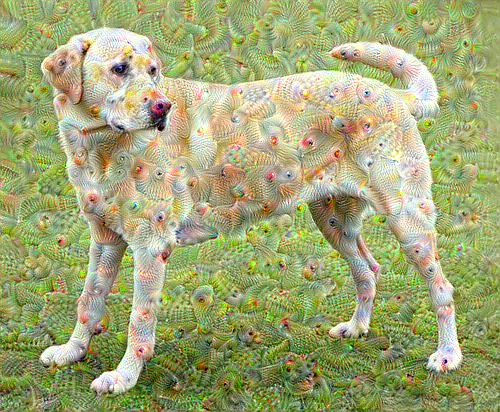

In [18]:
dream_img = run_deep_dream_simple(img=original_img, steps=100, step_size=0.01)